# 5. Analyze & Share phase
## 5.1 Feature Selection

I'll use some of the methods to select the features that would provide the best patterns or insights. These would be:

1. Correlation
2. Extra Trees Regressor
3. RFECV
4. Linear Regression
5. Lasso (L1 reg)
6. Ridge
7. Ensemble 
8. hyperparameter tuning


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time 
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/news_share_model_ready.csv')
print(df.shape)
df.head()

(999, 57)


,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,Channel_Tech,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares,month no,weekday no,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says,2014opens new,april 2014opens,fire tv.1,new window,new york,see also,social media,title_readability,text_readability
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0,March,Business,0,0,0,0,0,0.640816,5,3,1.0,4.579592,5,1459.500,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.25,0.25,1600,3,3,2441.637795,2316.046429,2312.036810,3,102,2,0,0,49,28,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59.97,-40.52
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0,April,Tech,0,0,0,0,1,0.549618,4,1,0.0,4.636704,7,0.000,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.00,0.00,1500,4,4,2233.879630,2316.046429,2676.025510,8,54,5,0,2,20,16,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,80.28,8.21
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0,April,Tech,0,0,0,0,1,0.577236,8,1,0.0,4.627451,7,2270.889,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.00,0.00,1400,4,4,2233.879630,2316.046429,2676.025510,8,239,3,1,3,103,56,53,0,0,0,0,0,0,0,5,5,0,17,0,0,0,80.28,-179.58
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,Tuesday,0,April,Tech,0,0,0,0,1,0.525896,4,1,0.0,5.083665,9,0.000,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.00,0.00,1300,4,4,2233.879630,2316.046429,2676.025510,5,141,2,1,2,67,42,26,0,0,0,0,0,0,0,0,0,0,2,0,1,0,32.56,-80.11
4,google launch improved android camera app repo...,android users may soon see series new features...,Tuesday,0,April,Others,0,0,1,0,0,0.588889,6,9,0.0,4.336022,7,3581.094,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.00,0.00,3000,4,4,2233.879630,2316.046429,2208.388571,8,148,5,2,1,62,49,31,0,0,0,0,0,0,1,0,0,0,1,0,0,0,71.82,-95.67


In [2]:
df.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month no', 'weekday no',
       'avg shares daily', 'avg shares weekly', 'avg shares by channel',
       'title_tokens', 'text_tokens', 'noun_count_title', 'verb_count_title',
       'adjective_count_title', 'noun_count_text', 'verb_count_text',
       'adjective_count_text', 'amazon fire', 'april fools', 'fire tv',
       'game thrones', 'google glass', 'need know', 'report says',
       '2014opens n

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               999 non-null    object 
 1   cleaned_text                999 non-null    object 
 2   weekday                     999 non-null    object 
 3   is_weekend                  999 non-null    int64  
 4   month                       999 non-null    object 
 5   cleaned_data_channel        999 non-null    object 
 6   Channel_Entertainment       999 non-null    int64  
 7   Channel_Lifestyle           999 non-null    int64  
 8   Channel_Others              999 non-null    int64  
 9   Channel_Social Media        999 non-null    int64  
 10  Channel_Tech                999 non-null    int64  
 11  unique_tokens_rate          999 non-null    float64
 12  num_hrefs                   999 non-null    int64  
 13  num_imgs                    999 non

## extras: Identifying outliers again as the model accuracy turned out abnormal

Columns like `is_weekend`, `month no`, `weekday no`, and categorical variables related to channels and tokens are not typically subjected to outlier clipping because they are categorical or represent discrete values.

In [4]:
num_df = df.drop(columns = ['cleaned_title', 'cleaned_text', 'weekday','month',
       'cleaned_data_channel',])
num_df.shape

(999, 52)

In [5]:
cols_to_treat = num_df.drop(columns = ['month no', 'weekday no','is_weekend', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech'])

In [6]:
cols_to_treat.shape

(999, 44)

Boxplot before clipping outliers

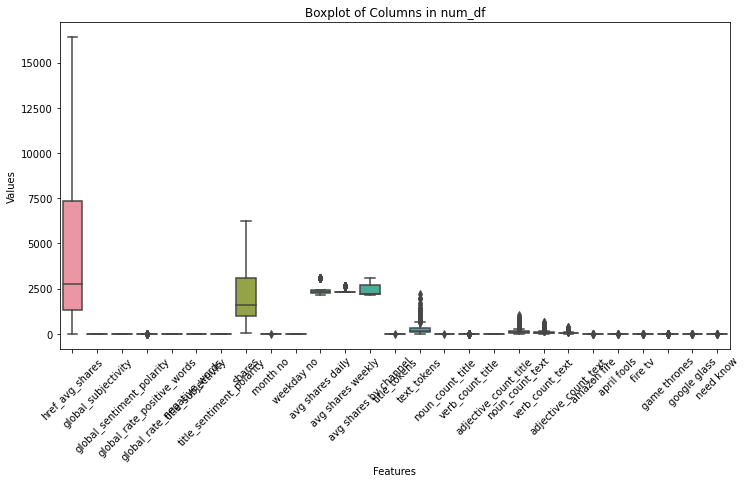

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot( data = num_df.iloc[:,15:42])

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in num_df')
plt.show()

In [8]:
print("\nDistribution (BEFORE outlier treatment):")
cols_to_treat.describe()


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says,2014opens new,april 2014opens,fire tv.1,new window,new york,see also,social media,title_readability,text_readability
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763,2366.762763,2366.762763,2366.762763,6.740741,254.267267,3.743744,1.349349,1.146146,117.890891,69.647648,49.148148,0.007007,0.007007,0.010010,0.023023,0.010010,0.008008,0.007007,0.378378,0.180180,0.124124,3.885886,0.214214,0.150150,0.154154,60.316406,-202.034094
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026,264.987744,116.628962,261.216199,1.612157,241.106151,1.330390,0.961731,0.929727,112.130833,69.618758,46.443774,0.083456,0.083456,0.099598,0.150052,0.099598,0.089173,0.083456,1.718394,0.838435,2.072486,6.577958,0.677552,0.365712,0.754585,26.597296,246.383643
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000,2157.572687,2316.046429,2139.983784,2.000000,14.000000,0.000000,0.000000,0.000000,5.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.020000,-2213.300000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000,2233.879630,2316.046429,2208.388571,6.000000,106.500000,3.000000,1.000000,0.000000,49.000000,28.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,46.440000,-272.620000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000,2284.658768,2316.046429,2208.388571,7.000000,176.000000,4.000000,1.000000,1.000000,82.000000,48.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,62.340000,-124.770000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000,2441.637795,2316.046429,2676.025510,8.000000,320.500000,5.000000,2.000000,2.000000,146.000000,86.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,80.280000,-50.845000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000,3088.297872,2634.698113,3106.109091,11.000000,2226.000000,9.000000,5.00

In [9]:
'''# Outlier treatment using IQR method
def treat_outliers_iqr(num, col):
    q1 = num[col].quantile(0.25)
    q3 = num[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return num

for col in cols_to_treat:
    num_df = treat_outliers_iqr(num_df, col)

print("\nDistribution (after outlier treatment using IQR method):")
cols_to_treat.describe()'''
def treat_outliers_iqr(num, col):
    q1 = num[col].quantile(0.25)
    q3 = num[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return num

num_df_treated = num_df.copy()

for col in cols_to_treat:
    num_df_treated = treat_outliers_iqr(num_df_treated, col)

print("\nDistribution (after outlier treatment using IQR method):")
cols_to_treat.describe()



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens,noun_count_title,verb_count_title,adjective_count_title,noun_count_text,verb_count_text,adjective_count_text,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says,2014opens new,april 2014opens,fire tv.1,new window,new york,see also,social media,title_readability,text_readability
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.532183,10.158158,4.260260,0.547548,4.675496,7.207207,1132.205907,5499.373117,3256.800153,4976.071248,0.450364,0.106496,0.037962,0.017433,0.293408,0.056851,2366.762763,2366.762763,2366.762763,2366.762763,6.740741,254.267267,3.743744,1.349349,1.146146,117.890891,69.647648,49.148148,0.007007,0.007007,0.010010,0.023023,0.010010,0.008008,0.007007,0.378378,0.180180,0.124124,3.885886,0.214214,0.150150,0.154154,60.316406,-202.034094
std,0.099346,7.654816,5.105337,0.807028,0.284113,1.859846,1181.656104,2231.951378,1047.739362,5258.348719,0.091591,0.087908,0.014989,0.009358,0.325482,0.170974,1812.447026,264.987744,116.628962,261.216199,1.612157,241.106151,1.330390,0.961731,0.929727,112.130833,69.618758,46.443774,0.083456,0.083456,0.099598,0.150052,0.099598,0.089173,0.083456,1.718394,0.838435,2.072486,6.577958,0.677552,0.365712,0.754585,26.597296,246.383643
min,0.272165,0.000000,0.000000,0.000000,3.942951,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224646,-0.114407,0.001300,0.000000,0.000000,-0.225000,58.000000,2157.572687,2316.046429,2139.983784,2.000000,14.000000,0.000000,0.000000,0.000000,5.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.020000,-2213.300000
25%,0.466835,4.000000,1.000000,0.000000,4.490862,6.000000,0.000000,3613.040000,2534.726000,1300.000000,0.395563,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000,2233.879630,2316.046429,2208.388571,6.000000,106.500000,3.000000,1.000000,0.000000,49.000000,28.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,46.440000,-272.620000
50%,0.533149,8.000000,2.000000,0.000000,4.685668,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102511,0.037325,0.016340,0.200000,0.000000,1600.000000,2284.658768,2316.046429,2208.388571,7.000000,176.000000,4.000000,1.000000,1.000000,82.000000,48.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,62.340000,-124.770000
75%,0.596615,14.000000,7.000000,1.000000,4.856136,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.162790,0.046892,0.022606,0.500000,0.150000,3100.000000,2441.637795,2316.046429,2676.025510,8.000000,320.500000,5.000000,2.000000,2.000000,146.000000,86.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,80.280000,-50.845000
max,0.791285,29.000000,16.000000,2.500000,5.404047,10.000000,3613.040000,10985.215000,5720.423500,16402.500000,0.680424,0.329107,0.074246,0.039680,1.000000,0.375000,6250.000000,3088.297872,2634.698113,3106.109091,11.000000,2226.000000,9.000000,5.00

Boxplot after clipping outliers

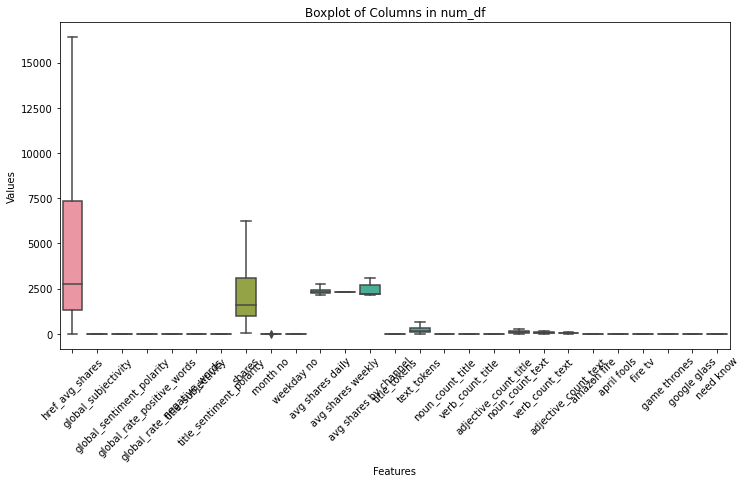

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot( data = num_df_treated.iloc[:,15:42])

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in num_df')
plt.show()

## 5.1.1 Correlations

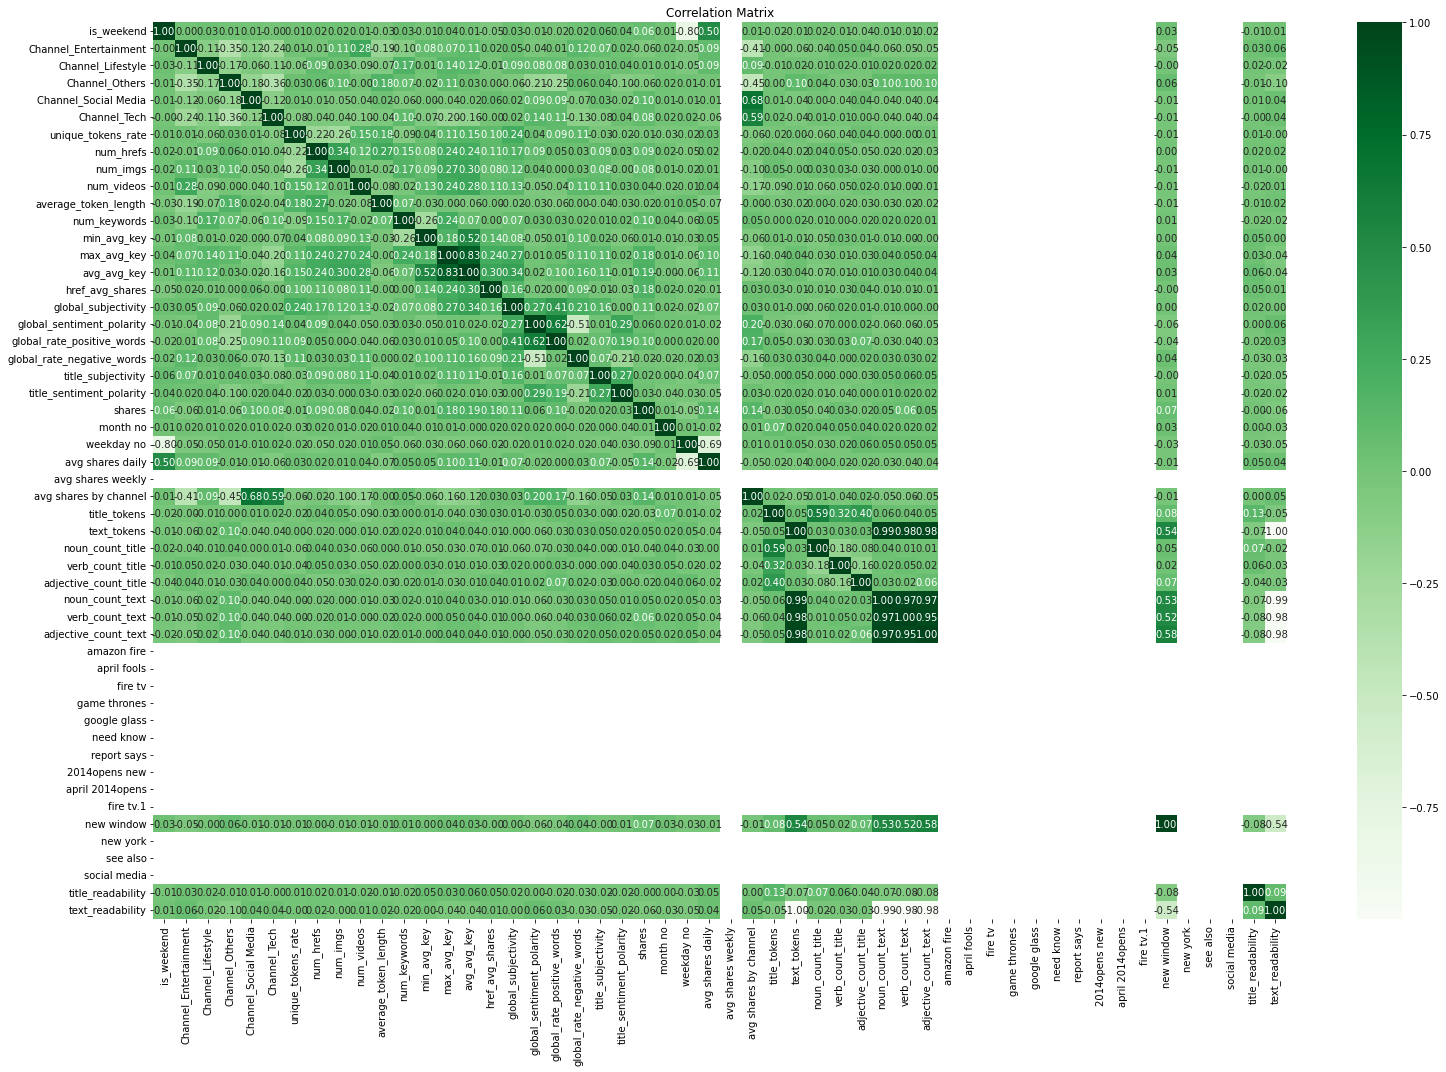

In [11]:


correlation_matrix = num_df_treated.corr()
plt.figure(figsize=(22, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [12]:

corr_with_target = correlation_matrix['shares'].sort_values(ascending=False)

top_correlated_features = corr_with_target[1:25]  
print(top_correlated_features)


avg_avg_key                   0.190891
href_avg_shares               0.180088
max_avg_key                   0.175701
avg shares by channel         0.144123
avg shares daily              0.142761
global_subjectivity           0.105557
num_keywords                  0.102101
global_rate_positive_words    0.099742
Channel_Social Media          0.098513
num_hrefs                     0.091711
Channel_Tech                  0.084343
num_imgs                      0.075050
new window                    0.066507
is_weekend                    0.064349
verb_count_text               0.063733
global_sentiment_polarity     0.055804
text_tokens                   0.054196
adjective_count_text          0.051020
noun_count_text               0.050920
num_videos                    0.038335
verb_count_title              0.032987
title_sentiment_polarity      0.031976
title_subjectivity            0.021661
month no                      0.013398
Name: shares, dtype: float64


### 5.1.2 Setting up our train and testing data

In [13]:
A = num_df.drop(columns=['shares'])  # Features (excluding 'shares')
b = num_df[['shares']]  # Target variable
#Creation phase..
A_train, A_test, b_train, b_test = train_test_split(A,b, test_size = 0.4, random_state=1234)

print(A.shape)
print(b.shape)

print((A_train.shape,A_test.shape), (b_train.shape,b_test.shape))

(999, 51)
(999, 1)
((599, 51), (400, 51)) ((599, 1), (400, 1))


'''/### Clipping outliers for the test data as well because I have found some and preventing the data leakage'''

In [14]:
'''plt.figure(figsize=(12, 6))
sns.boxplot( data = X_test)

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in X_test before clipping')
plt.show()'''

"plt.figure(figsize=(12, 6))\nsns.boxplot( data = X_test)\n\nplt.xticks(rotation=45)  \nplt.xlabel('Features')\nplt.ylabel('Values')\nplt.title('Boxplot of Columns in X_test before clipping')\nplt.show()"

In [15]:
'''
def treat_outliers_iqr(num, col):
    q1 = num[col].quantile(0.25)
    q3 = num[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return num

X_test_clipped = X_test.copy()

for col in X_test.columns:
    X_test_clipped = treat_outliers_iqr(X_test_clipped, col)

print("\nDistribution (after outlier treatment using IQR method):")
#cols_to_treat.describe()
plt.figure(figsize=(12, 6))
sns.boxplot( data = X_test)

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in X_test after clipping')
plt.show()'''

'\ndef treat_outliers_iqr(num, col):\n    q1 = num[col].quantile(0.25)\n    q3 = num[col].quantile(0.75)\n    iqr = q3 - q1\n    \n    lower_bound = q1 - 1.5 * iqr\n    upper_bound = q3 + 1.5 * iqr\n    \n    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers\n    return num\n\nX_test_clipped = X_test.copy()\n\nfor col in X_test.columns:\n    X_test_clipped = treat_outliers_iqr(X_test_clipped, col)\n\nprint("\nDistribution (after outlier treatment using IQR method):")\n#cols_to_treat.describe()\nplt.figure(figsize=(12, 6))\nsns.boxplot( data = X_test)\n\nplt.xticks(rotation=45)  \nplt.xlabel(\'Features\')\nplt.ylabel(\'Values\')\nplt.title(\'Boxplot of Columns in X_test after clipping\')\nplt.show()'

In [16]:
'''
def treat_outliers_iqr(num, col):
    q1 = num[col].quantile(0.25)
    q3 = num[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return num

X_train = X_train.copy()

for col in X_train.columns:
    X_train = treat_outliers_iqr(X_train, col)'''

'\ndef treat_outliers_iqr(num, col):\n    q1 = num[col].quantile(0.25)\n    q3 = num[col].quantile(0.75)\n    iqr = q3 - q1\n    \n    lower_bound = q1 - 1.5 * iqr\n    upper_bound = q3 + 1.5 * iqr\n    \n    num[col] = num[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers\n    return num\n\nX_train = X_train.copy()\n\nfor col in X_train.columns:\n    X_train = treat_outliers_iqr(X_train, col)'

### 5.1.3 Extra Trees Regressor (feature_importance_)

In [17]:
 
#fitting the train data
from sklearn.ensemble import ExtraTreesRegressor
choose = ExtraTreesRegressor()
choose.fit(A,b)

ExtraTreesRegressor()

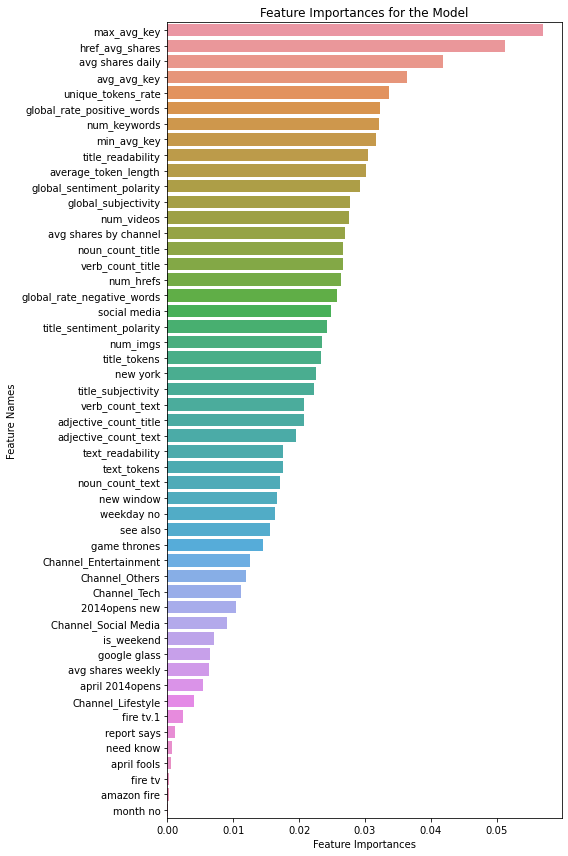

In [18]:
#showing in graph which are the important features we got..
feature_importances = choose.feature_importances_
feature_names = A.columns

# Create a DataFrame with feature importances and their corresponding names
sorted_feature_importances = pd.DataFrame({'Feature Importance': feature_importances, 'Feature Names': feature_names})

# Sort the DataFrame based on feature importances in descending order
sorted_feature_importances = sorted_feature_importances.sort_values(by='Feature Importance', ascending=False)

# Plotting the sorted feature importances

plt.figure(figsize=(8, 12))
sns.barplot(data=sorted_feature_importances, x='Feature Importance', y='Feature Names', )
plt.xlabel('Feature Importances')
plt.ylabel('Feature Names')
plt.title('Feature Importances for the Model')
#plt.savefig('fig-4.png')

plt.tight_layout()
plt.show()

In [19]:
sorted_feature_importances['Feature Names'].tolist()

['max_avg_key',
 'href_avg_shares',
 'avg shares daily',
 'avg_avg_key',
 'unique_tokens_rate',
 'global_rate_positive_words',
 'num_keywords',
 'min_avg_key',
 'title_readability',
 'average_token_length',
 'global_sentiment_polarity',
 'global_subjectivity',
 'num_videos',
 'avg shares by channel',
 'noun_count_title',
 'verb_count_title',
 'num_hrefs',
 'global_rate_negative_words',
 'social media',
 'title_sentiment_polarity',
 'num_imgs',
 'title_tokens',
 'new york',
 'title_subjectivity',
 'verb_count_text',
 'adjective_count_title',
 'adjective_count_text',
 'text_readability',
 'text_tokens',
 'noun_count_text',
 'new window',
 'weekday no',
 'see also',
 'game thrones',
 'Channel_Entertainment',
 'Channel_Others',
 'Channel_Tech',
 '2014opens new',
 'Channel_Social Media',
 'is_weekend',
 'google glass',
 'avg shares weekly',
 'april 2014opens',
 'Channel_Lifestyle',
 'fire tv.1',
 'report says',
 'need know',
 'april fools',
 'fire tv',
 'amazon fire',
 'month no']

In [20]:
selected_cols = ['max_avg_key',
 'href_avg_shares',
 'avg shares daily',
 'avg_avg_key',
 'unique_tokens_rate',
 'global_rate_positive_words',
 'num_keywords',
 'min_avg_key',
 'title_readability',
 'average_token_length',
 'global_sentiment_polarity',
 'global_subjectivity',
 'num_videos',
 'avg shares by channel',
 'noun_count_title',
 'verb_count_title',
 'num_hrefs',
 'global_rate_negative_words',
 'social media',
 'title_sentiment_polarity',
 'num_imgs',
 'title_tokens',
 'new york',
 'title_subjectivity',
 'verb_count_text',
 'adjective_count_title',
 'adjective_count_text',
 'text_readability',
 'text_tokens', 'noun_count_text',
 'new window',
 'weekday no',
 'see also',
 'game thrones',
 'Channel_Entertainment',
 'Channel_Others',
 'Channel_Tech',
 '2014opens new',
 'Channel_Social Media','shares']
selected_df = num_df_treated[selected_cols]
selected_df.head(2)

,max_avg_key,href_avg_shares,avg shares daily,avg_avg_key,unique_tokens_rate,global_rate_positive_words,num_keywords,min_avg_key,title_readability,average_token_length,global_sentiment_polarity,global_subjectivity,num_videos,avg shares by channel,noun_count_title,verb_count_title,num_hrefs,global_rate_negative_words,social media,title_sentiment_polarity,num_imgs,title_tokens,new york,title_subjectivity,verb_count_text,adjective_count_title,adjective_count_text,text_readability,text_tokens,shares
0,4817.692,1833.333,2441.637795,3370.415,0.640816,0.036735,5,1459.5,59.97,4.579592,0.038762,0.403762,1.0,2312.03681,2,0.0,5,0.024490,0,0.25,3,3,0,0.25,28,0,20,-40.52,102.0,1600
1,3581.094,8500.000,2233.879630,2556.367,0.549618,0.044944,7,0.0,80.28,4.636704,0.180934,0.410707,0.0,2676.02551,5,0.0,4,0.003745,0,0.00,1,8,0,0.00,16,2,12,8.21,54.0,1500


- **Setting up the X and y variable for all models to train**

In [21]:
X = selected_df.drop(columns=['shares'])  # Features (excluding 'shares')
y = selected_df[['shares']]  # Target variable
#Creation phase..
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=1234)

print(X.shape)
print(y.shape)

print((X_train.shape,X_test.shape), (y_train.shape,y_test.shape))

(999, 29)
(999, 1)
((599, 29), (400, 29)) ((599, 1), (400, 1))


### Removing outliers

In [23]:
import pandas as pd
cols2treat = ['max_avg_key',
 'href_avg_shares',
 'avg shares daily',
 'avg_avg_key',
 'unique_tokens_rate',
 'global_rate_positive_words',
 'num_keywords',
 'min_avg_key',
 'title_readability',
 'average_token_length',
 'global_sentiment_polarity',
 'global_subjectivity',
 'num_videos',
 'avg shares by channel',
 'noun_count_title',
 'verb_count_title',
 'num_hrefs',
 'global_rate_negative_words',
 'social media',
 'title_sentiment_polarity',
 'num_imgs',
 'title_tokens',
 'new york',
 'title_subjectivity',
 'verb_count_text',
 'adjective_count_title',
 'adjective_count_text',
 'text_readability',
 'text_tokens',]
def treat_outliers_iqr(data, cols_to_treat):
    data_copy = data.copy()
    
    for col in cols_to_treat:
        q1 = data_copy[col].quantile(0.25)
        q3 = data_copy[col].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data_copy[col] = data_copy[col].clip(lower=lower_bound, upper=upper_bound)

    return data_copy

# Treat outliers for X_train
X_train = treat_outliers_iqr(X_train, cols2treat)

# Treat outliers for X_test
X_test = treat_outliers_iqr(X_test, cols2treat)



**`Feature Scaling after splittting to remove Data Leakage`**

In [34]:
from sklearn.preprocessing import MinMaxScaler


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))


In [25]:
X_train

array([[0.58399791, 0.62109435, 0.48140741, ..., 0.74678112, 0.42155871,
        0.56223539],
       [0.51657926, 0.35055632, 0.21333822, ..., 0.45493562, 0.48570427,
        0.52328535],
       [0.32724368, 0.49620485, 0.48140741, ..., 0.23175966, 0.71588583,
        0.25402202],
       ...,
       [0.20336513, 0.14631916, 1.        , ..., 0.30042918, 0.69001091,
        0.2811177 ],
       [0.00416823, 1.        , 1.        , ..., 0.21459227, 0.75901599,
        0.23708721],
       [0.00550783, 0.23776863, 0.12809575, ..., 0.10300429, 0.87489544,
        0.0592718 ]])

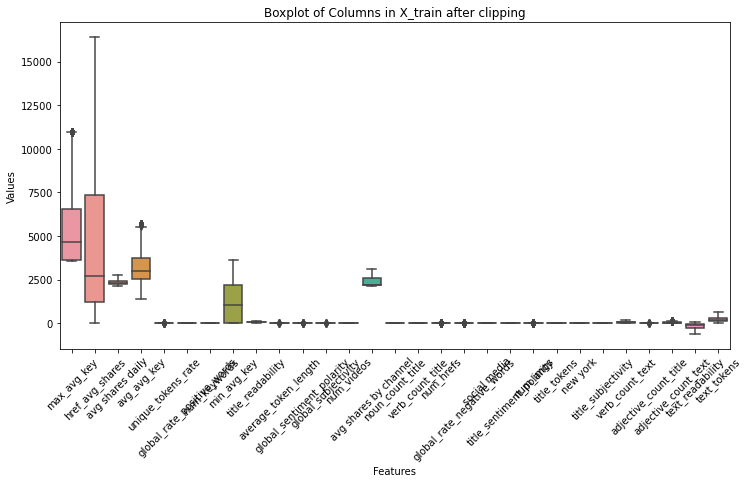

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot( data = X_train)

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in X_train after clipping')
plt.show()

In [21]:
'''plt.figure(figsize=(12, 6))
sns.boxplot( data = X_train)

plt.xticks(rotation=45)  
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Columns in X_test before clipping')
plt.show()'''

"plt.figure(figsize=(12, 6))\nsns.boxplot( data = X_train)\n\nplt.xticks(rotation=45)  \nplt.xlabel('Features')\nplt.ylabel('Values')\nplt.title('Boxplot of Columns in X_test before clipping')\nplt.show()"

### Hyperparameter tuning for RFR

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from scipy.stats import randint

#assigning the ensemble learning model
#rf_classifier = RandomForestClassifier()
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=1234) 
#generating the parameter distributions


param_dist = {
    'n_estimators': np.linspace(10, 100, num=10, dtype='int'),
    'max_depth': randint(1, 10),
    'max_features': ['auto', 'sqrt'],  # Added a comma here cz of dictionary
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

# Creating RandomizedSearchCV object

rf_comb = RandomizedSearchCV(
    estimator=rf_regressor, 
    param_distributions=param_dist, 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    cv=5, 
    random_state=1234,
    n_iter = 7
)
# Fitting
rf_comb.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=6, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=8, n_estimators=90; total time=   0.0s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, min_samples_split=8, n_estimators=90; total time= 

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
                   n_iter=7,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026945A47A30>,
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026945A471F0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026945A02820>,
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=1234, scoring='neg_mean_squared_error',
                   verbose=2)

In [71]:
#printing our best parameter
print(f'Best HyperParameters are: {rf_comb.best_params_}\n')
print("Best Score:", rf_comb.best_score_)

Best HyperParameters are: {'bootstrap': False, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 90}

Best Score: -3145476.398945852


In [73]:
#predicting and using it for later purposes
rsc_pred = rf_comb.predict(X_test)

In [74]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, rsc_pred))
print('R2:', metrics.r2_score(y_test, rsc_pred))
print('MSE:', metrics.mean_squared_error(y_test, rsc_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rsc_pred)))

MAE: 1402.2367548257566
R2: 0.0544035748198769
MSE: 3132210.3329629363
RMSE: 1769.8051680800731


## with gridsearchCV

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import metrics

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2']
}


rf_regressor = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)


y_pred = grid_search.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print("Test R2 Score:", test_r2)


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Test R2 Score: 0.03721674081631143


In [36]:
y_testest = y_test['shares'].values.ravel()

In [27]:
'''a = y_testest -rsc_pred
sns.histplot(a)
plt.show()'''

'a = y_testest -rsc_pred\nsns.histplot(a)\nplt.show()'

## neural network and hyperparameter

In [29]:
'''import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def build_nn_model(neurons=1024, n_layers=3):
    model = keras.Sequential()
    for _ in range(n_layers):
        model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# keras modelling
nn_regressor = KerasRegressor(build_fn=build_nn_model, verbose=0)

# Defininge the hyperparameter grid for tuning
param_grid = {
    'neurons': [256, 512, 1024],  
    'n_layers': [2, 3, 5],        
    'batch_size': [32, 64],       
    'epochs': [10, 20]            
}

# GridSearchCV
grid_search = GridSearchCV(estimator=nn_regressor, param_grid=param_grid, 
                           scoring='r2', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train, verbose=0)

# the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


y_pred = grid_search.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print("Test R2 Score:", test_r2)
'''

'import numpy as np\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import r2_score\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\nfrom tensorflow.keras.wrappers.scikit_learn import KerasRegressor\n\ndef build_nn_model(neurons=1024, n_layers=3):\n    model = keras.Sequential()\n    for _ in range(n_layers):\n        model.add(layers.Dense(neurons, activation=\'relu\'))\n    model.add(layers.Dense(1))  # Output layer for regression\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n    return model\n\n# keras modelling\nnn_regressor = KerasRegressor(build_fn=build_nn_model, verbose=0)\n\n# Defininge the hyperparameter grid for tuning\nparam_grid = {\n    \'neurons\': [256, 512, 1024],  \n    \'n_layers\': [2, 3, 5],        \n    \'batch_size\': [32, 64],       \n    \'epochs\': [10, 20]            \n}\n\n# GridSearchCV\ngrid_search = GridSearchCV(estimator=nn_regressor, param_grid=param_grid, \n                           sco

### 5.1.3 RFECV


In [32]:
#separating train and test
from sklearn.model_selection import train_test_split
#ensembling all by means of rf regressor since its a regresion problem
from sklearn.ensemble import RandomForestRegressor
#We will create a way by an algorithm that eliminates useless features after every iteration and obviously after an ensemble technique
from sklearn.feature_selection import RFECV
#finding the desired score
from sklearn.metrics import mean_squared_error

In [35]:


rfr = RandomForestRegressor()

#The negative sign is used because RFECV always maximizes the scoring metric, but we typically want to minimize the MSE.
rfecv = RFECV(estimator = rfr, cv =5, scoring ='neg_mean_squared_error')

In [36]:
#Fitting phase
rfecv.fit(X_train, y_train)
#getting the selected features by rfecv support into X_train
selected_features = X_train[selected_features][rfecv.support_]

NameError: name 'selected_features' is not defined

## 5.2 Ensembling(Random Forest Regressor)


In [ ]:
#ensembling phase
#fitting the train data
rfr.fit(X_train, y_train)
#finally predict on test data
y_pred = rfr.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
#scoring 
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2}')

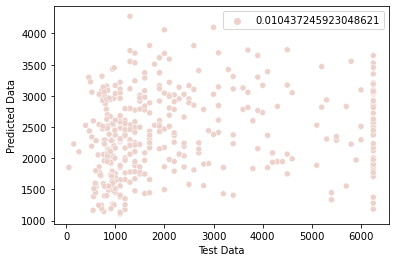

In [47]:
sns.scatterplot(x=y_testest, y=y_pred, hue=r2,alpha=1)
plt.xlabel("Test Data")
plt.ylabel("Predicted Data")

plt.show()

## 4. Linear Regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#X = selected_df.drop(columns=['shares'])  # Features (excluding 'shares')
#y = selected_df['shares']  # Target variable


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1234)


model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 0.09643487657825288
Root Mean Squared Error: 0.3105396537936063
R-squared: 0.07014117348451832
Coefficients: [[ 2.89802363e-02  1.07862551e-01  1.40480210e-01  2.05895522e-01
  -5.47949540e-02  1.58077061e-01  2.83341925e-02 -1.08703757e-01
  -7.09501929e-03  3.36152335e-02 -5.06433709e-02  2.41160324e-02
   2.28278741e-03  1.41688929e-01  5.01102639e-02  9.24240101e-02
  -4.93404697e-03 -1.27880754e-01  0.00000000e+00 -3.82774048e-02
  -5.06932733e-03 -2.01122349e-01 -1.66533454e-16 -4.59495237e-02
   3.04468022e-01  5.88976797e-02 -1.46213231e-01  5.37151459e-01
   4.79643707e-01]]
Intercept: [-0.34804001]


Again, the r-score is bad and wil be underfitting

## 5. Lasso Regression 

In [30]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

lasso_model = Lasso(alpha=1.0)  

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)




Mean Squared Error: 3299036.2906213496
Root Mean Squared Error: 1816.324940813551
R-squared: 0.08742945353864084


## XGB

In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("R2 Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)


R2 Score: 0.014963136776141805
Root Mean Squared Error (RMSE): 1806.3370499204877


## SVR

In [51]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_model = SVR(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("R2 Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)


R2 Score: -0.008338693638992423
Root Mean Squared Error (RMSE): 1827.5773399105306


### model -3 

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Step 1: Train-Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Cross-Validation
model = RandomForestRegressor()  # You can use other models as well
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R2 Scores:", scores)

# Step 3: Regularization 
#  with Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Adjust the alpha parameter for stronger/weaker regularization
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 Score with Ridge Regression on Test Data:", r2)

final_model = RandomForestRegressor()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)
print("Final R2 Score on Test Data:", final_r2)


Cross-Validation R2 Scores: [-0.03092066  0.07525192  0.04912612 -0.016692    0.05885813]
R2 Score with Ridge Regression on Test Data: 0.09595708408667891
Final R2 Score on Test Data: 0.031411314428210435


# ROUGH
-----
### practices of other models


In [95]:
pi=0.95
one_minus_pi = 1 - pi
ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
z_score

1.959963984540054

In [96]:
def get_interval_estimate(actual_values, predicted_values, pi=.95):
    '''
    Get the interval estimate for the regression model.
    
    INPUTS: 
        - actual_values (y_train)
        - predicted_values (prediction from x_train)
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Interval estimate
    '''
    
    #get standard deviation of prediction on the train dataset
    sum_errs = np.sum((actual_values - predicted_values)**2)
    stdev = np.sqrt(sum_errs / (len(actual_values) - 1))
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
    z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
    interval = z_score * stdev

    return interval
def get_prediction_interval(prediction, actual_values, predicted_values, pi=.95):
    '''
    Get a prediction interval for the regression model.
    
    INPUTS: 
        - Single prediction (test data), 
        - y_train
        - prediction from x_train,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single test prediction
    '''
    
    #get standard deviation of prediction on the train dataset
    sum_errs = np.sum((actual_values - predicted_values)**2)
    stdev = np.sqrt(sum_errs / (len(actual_values) - 1))
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
    z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
    interval = z_score * stdev
    
    
    #generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower[0], upper[0]

In [123]:
# Model training
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)
print("Training R2 score: "+ str(linear_reg.score(X_train,y_train)))

Training R2 score: 0.13161660356145555


In [122]:
preds_lr = linear_reg.predict(X_test)

print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_lr)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_lr)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_lr))))

Test R2 score: 0.14270948572108821
Test MAE: 0.20838454763039835
Test RMSE: 0.2765248130779181


In [126]:
#pd.DataFrame(zip(linear_reg.coef_.T, X_train.columns))


array([[2.15379678e-01, 1.15836001e-01, 0.00000000e+00, ...,
        5.45454545e-01, 2.98146656e-01, 3.14049587e-01],
       [2.49137547e-02, 1.00000000e+00, 0.00000000e+00, ...,
        1.81818182e-01, 1.65995165e-01, 1.90082645e-01],
       [4.35389670e-03, 3.90184423e-01, 2.13338220e-01, ...,
        0.00000000e+00, 9.50846092e-02, 1.57024793e-01],
       ...,
       [3.29720637e-01, 1.00000000e+00, 1.28095754e-01, ...,
        0.00000000e+00, 3.96454472e-01, 2.72727273e-01],
       [6.10813008e-04, 9.14494742e-02, 1.28095754e-01, ...,
        9.09090909e-02, 6.44641418e-02, 6.61157025e-02],
       [2.32626718e-02, 5.40771224e-02, 0.00000000e+00, ...,
        9.09090909e-02, 4.80257857e-01, 4.79338843e-01]])

In [124]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train,y_train)
print("Training R2 score: "+ str(ridge.score(X_train,y_train)))

Training R2 score: 0.13050099639879698


In [125]:
preds_rid = ridge.predict(X_test)

print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_rid)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_rid)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_rid))))

Test R2 score: 0.09595708408667891
Test MAE: 0.22616694993475966
Test RMSE: 0.28396487406486925


## Hyperparameter tuning for LR

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

#taking linear_reg from the helper function and the linear regression we did down
grid_search = GridSearchCV(linear_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('R2:', metrics.r2_score(y_test, y_pred))

Best Hyperparameters: {'fit_intercept': True, 'positive': True}
Mean Squared Error: 0.08144697854830507
R2: 0.08686543734923391


In [60]:
'''num_df_treated['global_sentiment_polarity'] = num_df_treated['global_sentiment_polarity'].abs()
num_df_treated['title_sentiment_polarity'] = num_df_treated['title_sentiment_polarity'].abs()'''


"num_df_treated['global_sentiment_polarity'] = num_df_treated['global_sentiment_polarity'].abs()\nnum_df_treated['title_sentiment_polarity'] = num_df_treated['title_sentiment_polarity'].abs()"

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_regressor = RandomForestRegressor(n_estimators=100, random_state=2)  # You can adjust hyperparameters


rf_regressor.fit(X_train, y_train)


y_pred_rf = rf_regressor.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"R-squared: {r2_rf}")


NameError: name 'X_train' is not defined